# Analytical 1D Doppler Solver

This notebook demonstrates how to use rydiqule's prototype implementation of the analytical 1D doppler solver described in
Omar Nagib and Thad G. Walker, *Exact steady state of perturbed open quantum systems*,
arXiv 2501.06134 (2025) http://arxiv.org/abs/2501.06134
It currently contains development work, including detailed profiling performance, as the features are being worked on.

We will look at a simple case of Autler-Townes splitting in Rubidium-87 with two optical fields (blue and red). Applying an RF tone at different field strengths causes the central peak to split and shift as we scan the probe detuning. We show excellent agreement between numerically integrating the effect of Doppler broadening and the new exact method.


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%load_ext line_profiler

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import rydiqule as rq

In [40]:
# parameters for Cell
atom = 'Rb87'

states = [
    rq.ground_state(atom),
    rq.D2_excited(atom),
    rq.A_QState(41,2,5/2),
    rq.A_QState(40,3,7/2)
]


cell = rq.Cell(atom, states)

In [41]:
# laser parameters
detunings = 2*np.pi*np.linspace(-30,30,201)
Omega_r = 2*np.pi*2
Omega_b = 2*np.pi*5
Omega_rf = 2*np.pi*np.array([0,5,40])

kunit1 = np.array([1,0,0])
kunit2 = np.array([-1,0,0])

red = {'states': (states[0],states[1]), 'detuning': detunings, 'rabi_frequency': Omega_r, 'kunit': kunit1}
blue = {'states': (states[1],states[2]), 'detuning': 0, 'rabi_frequency': Omega_b, 'kunit': kunit2}
rf = {'states': (states[2],states[3]), 'detuning': 0, 'rabi_frequency': Omega_rf}

cell.add_couplings(red, blue, rf)

In [42]:
def compare_accuracy(sol1: np.ndarray, sol2: np.ndarray,
                     rtol: float = 1e-5, atol: float = 1e-7):
    """Helper function for summarizing relative and absolute differences between
    density matrix solutions.
    
    Note that sol1 is considered the 'correct' solution in the comparison.
    
    Tolerances are passed to numpy.isclose for defining how close something is."""

    assert sol1.shape == sol2.shape, 'solutions must have same shape to be compared'
    abs_diff = np.abs(sol2 - sol1)
    null_elem = np.isclose(sol1, 0.0)
    sol_ref = sol1.copy()
    sol_ref[null_elem] = 1.0
    rel_diff = abs_diff/np.abs(sol_ref)
    rel_diff[null_elem] = 0.0
    print(f'Abs(diff) max {abs_diff.max():.3e}, mean {abs_diff.mean():.3g}, std {abs_diff.std():.3g}')
    print(f'Rel(diff) max {rel_diff.max():.3e}, mean {rel_diff.mean():.3g}, std {rel_diff.std():.3g}')

    close = np.isclose(sol2, sol1, rtol=rtol, atol=atol)  # element-wise close
    close_sys = close.all(axis=-1)  # density-matrix wise close
    if not close_sys.all():
        print(f'Not close matrix elements {(~close).sum():d} out of {close.size:d} total')
        print(f'Not close solutions {(~close_sys).sum():d} out of {close_sys.size:d} total')
        not_close_inds = (~close).nonzero()
        vals, counts = np.unique(not_close_inds[2], return_counts=True)
        for l, v, c in zip(cell.dm_basis(), vals, counts):
            print(f'\tdm element {l:s}-[{v:d}] has {c:d} misses: ' +
                  f'Abs-diff (max, mean, diff) {abs_diff[...,v].max():.3e}, {abs_diff[...,v].mean():.3e}, {abs_diff[...,v].std():.3e}')
        return not_close_inds

In [43]:
%%time
sol_riemann = rq.solve_steady_state(cell, doppler=True)

CPU times: total: 1.03 s
Wall time: 1 s


In [44]:
dop_mesh_method = {'method': 'split',
                   'width_doppler': 2.0,
                   'n_doppler': 201,
                   'width_coherent': 0.28,
                   'n_coherent': 1001}

In [45]:
%%time
sol_riemann_finer = rq.solve_steady_state(cell, doppler=True, doppler_mesh_method=dop_mesh_method)

CPU times: total: 2.08 s
Wall time: 2.1 s


In [46]:
%%time
sol_exact = rq.doppler_1d_exact(cell)

CPU times: total: 46.9 ms
Wall time: 53.4 ms


In [47]:
bad_inds = compare_accuracy(sol_exact.rho, sol_riemann.rho, rtol=1e-5, atol=7e-5)

Abs(diff) max 4.852e-04, mean 3.08e-05, std 6.43e-05
Rel(diff) max 1.963e+03, mean 1.19, std 30.3
Not close matrix elements 1313 out of 9045 total
Not close solutions 507 out of 603 total
	dm element 01_real-[1] has 409 misses: Abs-diff (max, mean, diff) 4.852e-04, 1.435e-04, 1.140e-04
	dm element 02_real-[2] has 238 misses: Abs-diff (max, mean, diff) 4.385e-04, 7.979e-05, 9.618e-05
	dm element 03_real-[9] has 327 misses: Abs-diff (max, mean, diff) 3.313e-04, 8.965e-05, 7.331e-05
	dm element 01_imag-[10] has 118 misses: Abs-diff (max, mean, diff) 2.891e-04, 3.663e-05, 4.974e-05
	dm element 11_real-[14] has 221 misses: Abs-diff (max, mean, diff) 3.348e-04, 6.056e-05, 7.086e-05


In [48]:
bad_inds_finer = compare_accuracy(sol_exact.rho, sol_riemann_finer.rho, rtol=1e-5, atol=7e-5)

Abs(diff) max 6.090e-05, mean 3.31e-06, std 7.83e-06
Rel(diff) max 1.280e+02, mean 0.14, std 2.1


In [49]:
bad_inds_riemann = compare_accuracy(sol_riemann_finer.rho, sol_riemann.rho, rtol=1e-5, atol=7e-5)

Abs(diff) max 4.882e-04, mean 3.1e-05, std 6.47e-05
Rel(diff) max 2.135e+02, mean 0.53, std 4.1
Not close matrix elements 1345 out of 9045 total
Not close solutions 507 out of 603 total
	dm element 01_real-[1] has 407 misses: Abs-diff (max, mean, diff) 4.882e-04, 1.432e-04, 1.138e-04
	dm element 02_real-[2] has 256 misses: Abs-diff (max, mean, diff) 4.490e-04, 8.210e-05, 9.933e-05
	dm element 03_real-[9] has 325 misses: Abs-diff (max, mean, diff) 3.406e-04, 8.887e-05, 7.339e-05
	dm element 01_imag-[10] has 134 misses: Abs-diff (max, mean, diff) 3.044e-04, 3.857e-05, 5.220e-05
	dm element 11_real-[14] has 223 misses: Abs-diff (max, mean, diff) 3.407e-04, 5.994e-05, 7.061e-05


In [50]:
%timeit rq.doppler_1d_exact(cell)

51.8 ms ± 1.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [51]:
%lprun -f rq.doppler_1d_exact rq.doppler_1d_exact(cell)

Timer unit: 1e-07 s

Total time: 0.0605242 s
File: C:\Users\RydbergControl\Documents\GitHub\rydiqulepublic\src\rydiqule\doppler_exact.py
Function: doppler_1d_exact at line 127

Line #      Hits         Time  Per Hit   % Time  Line Contents
   127                                           def doppler_1d_exact(sensor: Sensor, rtol: float = 1e-5, atol: float = 1e-9) -> Solution:
   128                                               """
   129                                               Analytically solves a sensor in steady-state in the presence of 1 dimensional
   130                                               Doppler broadening.
   131                                           
   132                                               Uses the method outlined in Ref [1]_.
   133                                               In particular, it uses Eq. 14 to analytically evaluate the Doppler average in 1D.
   134                                           
   135                            

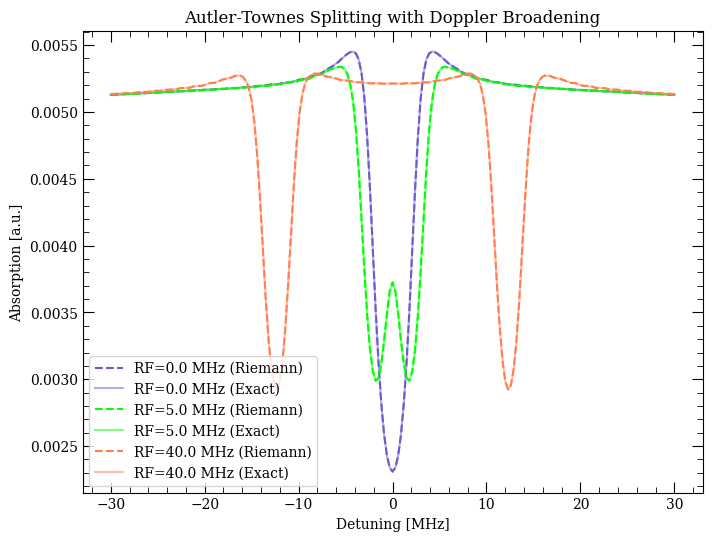

In [52]:
colors=['slateblue', 'lime', 'coral']
plt.figure(figsize=(8,6))
for i in range(len(Omega_rf)):
    plt.plot(detunings/(2*np.pi), rq.get_rho_ij(sol_riemann,1,0)[:,i].imag,
             label=f'RF={Omega_rf[i]/(2*np.pi):.1f} MHz (Riemann)', c=colors[i], linestyle='dashed')
    plt.plot(detunings/(2*np.pi), rq.get_rho_ij(sol_exact,1,0)[:,i].imag,
             label=f'RF={Omega_rf[i]/(2*np.pi):.1f} MHz (Exact)', c=colors[i], alpha=0.5)
plt.xlabel('Detuning [MHz]')
plt.ylabel('Absorption [a.u.]')
plt.legend()
plt.title('Autler-Townes Splitting with Doppler Broadening')
plt.show()

In [53]:
rq.about()


        Rydiqule
    
Rydiqule Version:     2.0.1.dev7
Installation Path:    ~\Documents\GitHub\rydiqulepublic\src\rydiqule

      Dependencies
    
NumPy Version:        2.3.0
SciPy Version:        1.15.3
Matplotlib Version:   3.10.3
ARC Version:          3.8.1
Python Version:       3.12.11
Python Install Path:  ~\miniconda3\envs\rydiqule1
Platform Info:        Windows (AMD64)
CPU Count and Freq:   16 @ 3.91 GHz
Total System Memory:  256 GB
